In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [2]:
df = pd.read_csv('../datasets/train.csv')
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
df.shape

(2051, 81)

In [4]:
df.iloc[:,:40].isna().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       330
Lot Area             0
Street               0
Alley             1911
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        22
Mas Vnr Area        22
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
dtype: int64

In [5]:
df.iloc[:,40:].isna().sum()

Heating               0
Heating QC            0
Central Air           0
Electrical            0
1st Flr SF            0
2nd Flr SF            0
Low Qual Fin SF       0
Gr Liv Area           0
Bsmt Full Bath        2
Bsmt Half Bath        2
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual          0
TotRms AbvGrd         0
Functional            0
Fireplaces            0
Fireplace Qu       1000
Garage Type         113
Garage Yr Blt       114
Garage Finish       114
Garage Cars           1
Garage Area           1
Garage Qual         114
Garage Cond         114
Paved Drive           0
Wood Deck SF          0
Open Porch SF         0
Enclosed Porch        0
3Ssn Porch            0
Screen Porch          0
Pool Area             0
Pool QC            2042
Fence              1651
Misc Feature       1986
Misc Val              0
Mo Sold               0
Yr Sold               0
Sale Type             0
SalePrice             0
dtype: int64

#### While hand-selecting variables, I eliminated features with insufficient data or data that is not significantly correlated with Sale Price.

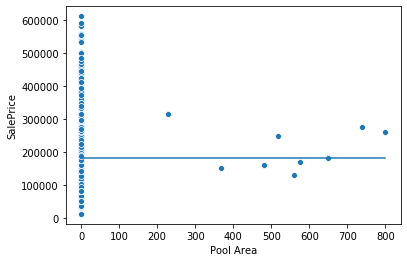

In [6]:
sns.scatterplot(df['Pool Area'], df['SalePrice']);
sns.lineplot(x=df['Pool Area'], y=df['SalePrice'].mean());

In [7]:
print(f"Average House with Pool Sale Price: ${round(df['SalePrice'][df['Pool Area'] > 100].mean(), 2)}")
print(f"Average House Sale Price: ${round(df['SalePrice'].mean(), 2)}")
print(f"Number of Houses with Pools: {len(df[df['Pool Area'] > 1])}")

Average House with Pool Sale Price: $210552.22
Average House Sale Price: $181469.7
Number of Houses with Pools: 9


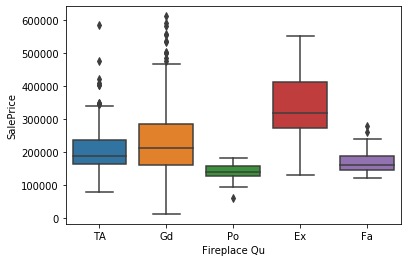

In [8]:
sns.boxplot(df['Fireplace Qu'], df['SalePrice'])

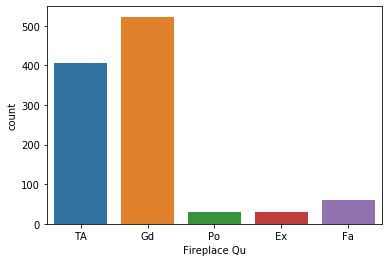

In [9]:
sns.countplot(df['Fireplace Qu'])

In [10]:
df['Fireplace Qu'].value_counts(normalize=True)

Gd    0.497621
TA    0.387250
Fa    0.056137
Ex    0.029496
Po    0.029496
Name: Fireplace Qu, dtype: float64

In [11]:
df['Fireplace Qu'].isna().sum()

1000

#### These two features, Pool Area and Fireplace Qu(ality), were eliminated for different reasons. For Pool Area, I deemed 9 total data points insufficient to determine a real trend with Sale Price. For Fireplace Quality, the two categories which house 90% of the data have roughly the same mean value; also, the feature is missing 1000 values.

## Here starts the data cleaning

In [12]:
relevant_cols = ['Lot Frontage', 'Lot Area', 'Neighborhood', 'Overall Qual', 'Year Built',
                 'Year Remod/Add', 'Exter Qual', 'Foundation', 'Bsmt Qual', 'Total Bsmt SF',
                 '1st Flr SF', 'Gr Liv Area', 'TotRms AbvGrd', 'Garage Yr Blt',
                'Garage Finish', 'Garage Cars', 'Garage Area', 'SalePrice']

In [13]:
new_df = df[relevant_cols]

In [14]:
def scatter(feature, data=new_df):
    return sns.scatterplot(x=feature, y='SalePrice', data=data)
def histogram(feature, data=new_df):
    return sns.distplot(data[feature])
def boxplot(feature, data=new_df):
    return sns.boxplot(x=feature, y='SalePrice', data=data)
def countplot(feature, data=new_df):
    return sns.countplot(data[feature])
def nas(feature, data=new_df):
    return data[feature].isna().sum()

In [15]:
new_df.isna().sum()

Lot Frontage      330
Lot Area            0
Neighborhood        0
Overall Qual        0
Year Built          0
Year Remod/Add      0
Exter Qual          0
Foundation          0
Bsmt Qual          55
Total Bsmt SF       1
1st Flr SF          0
Gr Liv Area         0
TotRms AbvGrd       0
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
SalePrice           0
dtype: int64

In [16]:
new_df.dtypes

Lot Frontage      float64
Lot Area            int64
Neighborhood       object
Overall Qual        int64
Year Built          int64
Year Remod/Add      int64
Exter Qual         object
Foundation         object
Bsmt Qual          object
Total Bsmt SF     float64
1st Flr SF          int64
Gr Liv Area         int64
TotRms AbvGrd       int64
Garage Yr Blt     float64
Garage Finish      object
Garage Cars       float64
Garage Area       float64
SalePrice           int64
dtype: object

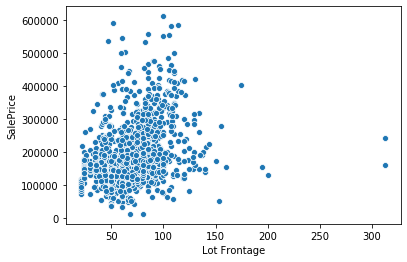

In [17]:
scatter('Lot Frontage');

In [18]:
nas('Lot Frontage')

330

In [19]:
new_df['Lot Frontage'] = new_df['Lot Frontage'].fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
nas('Lot Frontage')

0

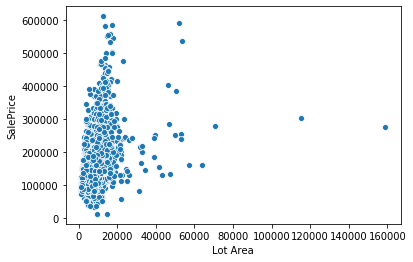

In [21]:
scatter('Lot Area');

In [22]:
nas('Lot Area')

0

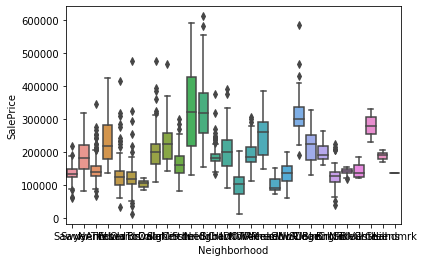

In [23]:
boxplot('Neighborhood');

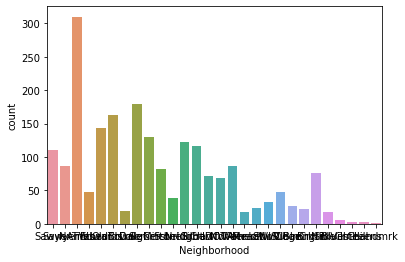

In [24]:
countplot('Neighborhood');

In [25]:
nas('Neighborhood')

0

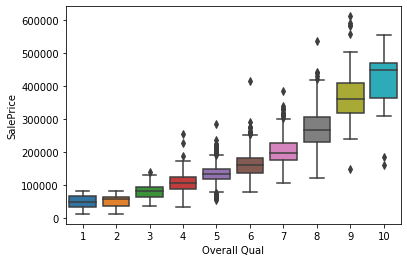

In [26]:
boxplot('Overall Qual');

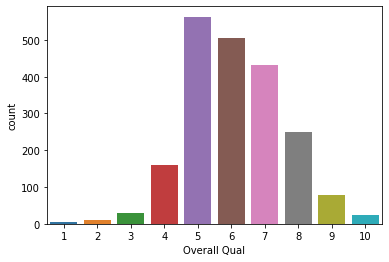

In [27]:
countplot('Overall Qual');

In [28]:
nas('Overall Qual')

0

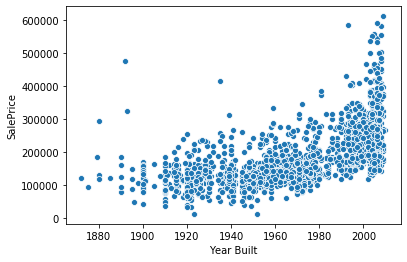

In [29]:
scatter('Year Built');

In [30]:
nas('Year Built')

0

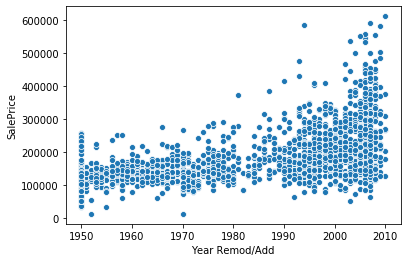

In [31]:
scatter('Year Remod/Add');

In [32]:
nas('Year Remod/Add')

0

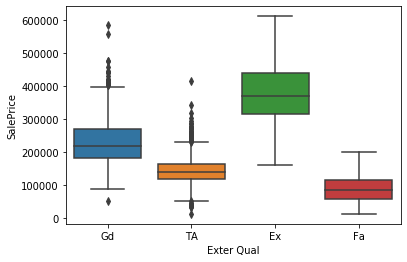

In [33]:
boxplot('Exter Qual');

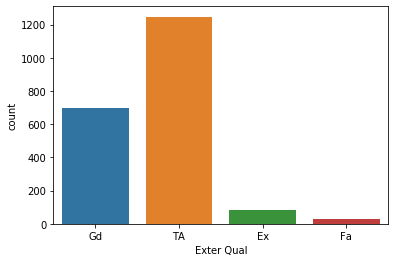

In [34]:
countplot('Exter Qual');

In [35]:
nas('Exter Qual')

0

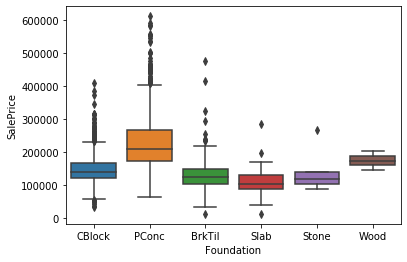

In [36]:
boxplot('Foundation');

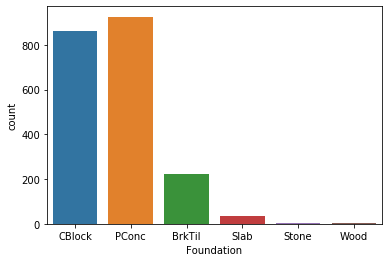

In [37]:
countplot('Foundation');

In [38]:
nas('Foundation')

0

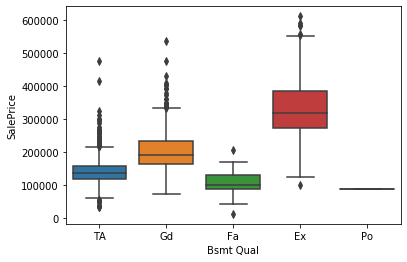

In [39]:
boxplot('Bsmt Qual');

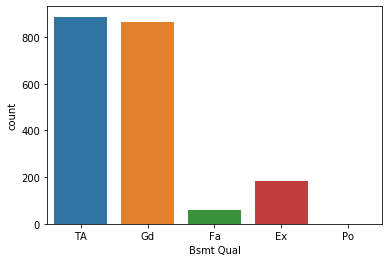

In [40]:
countplot('Bsmt Qual');

In [41]:
nas('Bsmt Qual')

55

In [42]:
new_df[new_df['Bsmt Qual'].isna() == True]['SalePrice'].describe()

count        55.000000
mean     106341.345455
std       44146.716034
min       13100.000000
25%       82250.000000
50%      100000.000000
75%      125500.000000
max      284700.000000
Name: SalePrice, dtype: float64

In [43]:
new_df[new_df['Bsmt Qual'] == 'Fa']['SalePrice'].describe()

count        60.000000
mean     107752.166667
std       34059.476797
min       12789.000000
25%       87350.000000
50%      100950.000000
75%      129750.000000
max      206900.000000
Name: SalePrice, dtype: float64

In [44]:
new_df['Bsmt Qual'] = new_df['Bsmt Qual'].fillna('Fa')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
nas('Bsmt Qual')

0

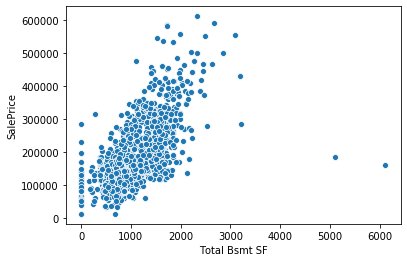

In [46]:
scatter('Total Bsmt SF');

In [47]:
nas('Total Bsmt SF')

1

In [48]:
new_df['Total Bsmt SF'] = new_df['Total Bsmt SF'].fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [49]:
nas('Total Bsmt SF')

0

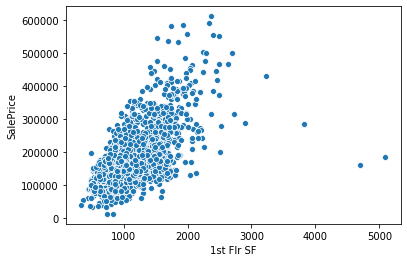

In [50]:
scatter('1st Flr SF');

In [51]:
nas('1st Flr SF')

0

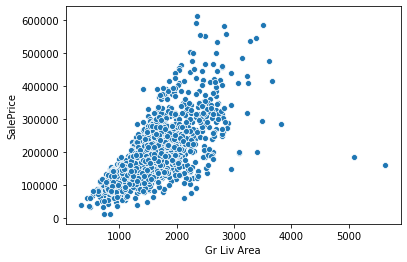

In [52]:
scatter('Gr Liv Area');

In [53]:
nas('Gr Liv Area')

0

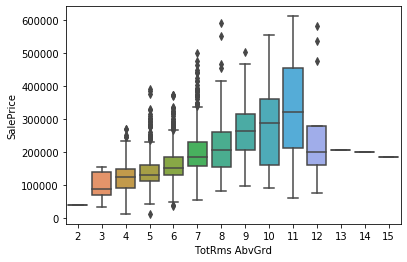

In [54]:
boxplot('TotRms AbvGrd');

In [55]:
nas('TotRms AbvGrd')

0

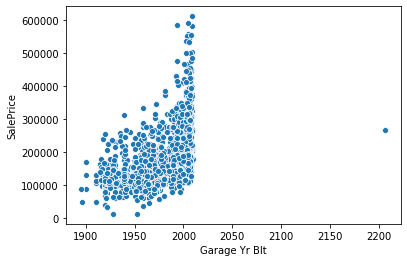

In [56]:
scatter('Garage Yr Blt');

In [57]:
new_df['Garage Yr Blt'].idxmax()

1699

In [58]:
new_df.loc[1699, 'Garage Yr Blt'] = 2007

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


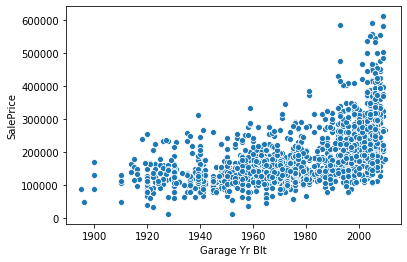

In [59]:
scatter('Garage Yr Blt');

In [60]:
nas('Garage Yr Blt')

114

In [61]:
new_df[new_df['Garage Yr Blt'].isna() == True]['SalePrice'].describe()

count       114.000000
mean     106065.991228
std       33821.754228
min       34900.000000
25%       82406.250000
50%      105125.000000
75%      128712.500000
max      200500.000000
Name: SalePrice, dtype: float64

In [62]:
years_mean = (new_df['Garage Yr Blt'] - new_df['Year Built']).mean()
years_mean

5.189984512132163

In [63]:
new_df['Garage Yr Blt'] = new_df['Garage Yr Blt'].fillna(new_df['Year Built'] + years_mean)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
nas('Garage Yr Blt')

0

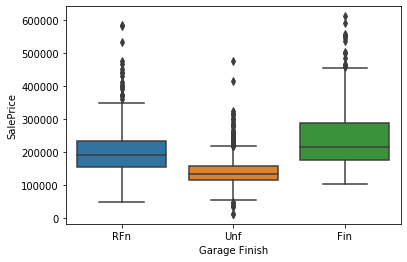

In [65]:
boxplot('Garage Finish');

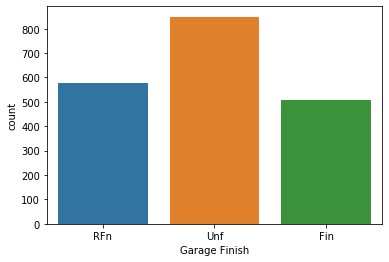

In [66]:
countplot('Garage Finish');

In [67]:
nas('Garage Finish')

114

In [68]:
df[(df['Garage Finish'].isna() == True) & (df['Garage Yr Blt'].isna() == True)].shape

(114, 81)

In [69]:
new_df[new_df['Garage Finish'].isna() == True]['SalePrice'].describe()

count       114.000000
mean     106065.991228
std       33821.754228
min       34900.000000
25%       82406.250000
50%      105125.000000
75%      128712.500000
max      200500.000000
Name: SalePrice, dtype: float64

In [70]:
new_df[new_df['Garage Finish'] == 'Unf']['SalePrice'].describe()

count       849.000000
mean     140718.148410
std       44434.590021
min       12789.000000
25%      115400.000000
50%      135000.000000
75%      157000.000000
max      475000.000000
Name: SalePrice, dtype: float64

In [71]:
new_df['Garage Finish'] = new_df['Garage Finish'].fillna('NR')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


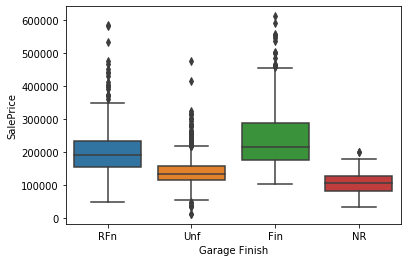

In [72]:
boxplot('Garage Finish');

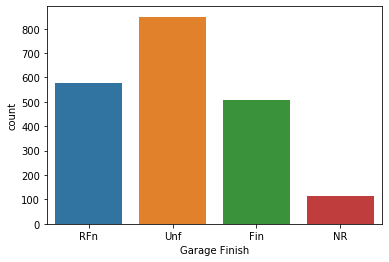

In [73]:
countplot('Garage Finish');

In [74]:
nas('Garage Finish')

0

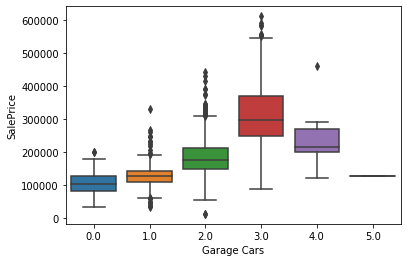

In [75]:
boxplot('Garage Cars');

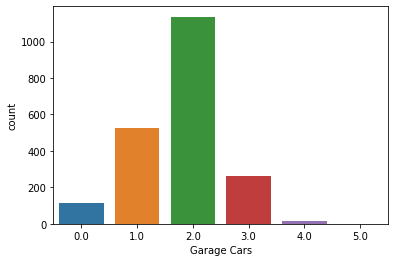

In [76]:
countplot('Garage Cars');

In [77]:
nas('Garage Cars')

1

In [78]:
new_df[new_df['Garage Cars'].isna() == True]['SalePrice']

1712    150909
Name: SalePrice, dtype: int64

In [79]:
new_df[new_df['Garage Cars'] == 1.0]['SalePrice'].mean()

126824.59160305343

In [80]:
new_df['Garage Cars'] = new_df['Garage Cars'].fillna(1.0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
nas('Garage Cars')

0

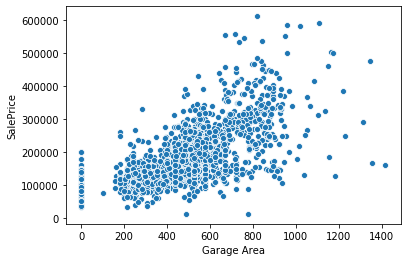

In [82]:
scatter('Garage Area');

In [83]:
nas('Garage Area')

1

In [84]:
new_df[new_df['Garage Area'].isna() == True]

,Lot Frontage,Lot Area,Neighborhood,Overall Qual,Year Built,Year Remod/Add,Exter Qual,Foundation,Bsmt Qual,Total Bsmt SF,1st Flr SF,Gr Liv Area,TotRms AbvGrd,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,SalePrice
1712,50.0,9060,IDOTRR,5,1923,1999,TA,BrkTil,Gd,859.0,942,1828,6,1928.189985,NR,1.0,NaN,150909


In [85]:
garage_area_mean = new_df['Garage Area'].mean()
garage_area_mean

473.6717073170732

In [86]:
new_df['Garage Area'] = new_df['Garage Area'].fillna(garage_area_mean)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
nas('Garage Area')

0

In [88]:
new_df.columns

Index(['Lot Frontage', 'Lot Area', 'Neighborhood', 'Overall Qual',
       'Year Built', 'Year Remod/Add', 'Exter Qual', 'Foundation', 'Bsmt Qual',
       'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'TotRms AbvGrd',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
       'SalePrice'],
      dtype='object')

In [89]:
new_df.corr()['SalePrice'].sort_values(ascending=False)

SalePrice         1.000000
Overall Qual      0.800207
Gr Liv Area       0.697038
Garage Area       0.650246
Garage Cars       0.648225
Total Bsmt SF     0.629303
1st Flr SF        0.618486
Year Built        0.571849
Garage Yr Blt     0.552957
Year Remod/Add    0.550370
TotRms AbvGrd     0.504014
Lot Area          0.296566
Lot Frontage      0.181456
Name: SalePrice, dtype: float64

### Here Starts Feature Engineering

In [90]:
new_df['Garage Cars'].unique()

array([2., 1., 3., 0., 4., 5.])

In [91]:
car_mean_dict = {key: new_df[new_df['Garage Cars'] == value]['SalePrice'].mean()
                 for key, value in enumerate(range(6))}
new_df['Garage Car Means'] = new_df['Garage Cars'].replace(to_replace=car_mean_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
new_df['Exter Qual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [93]:
exter_qual_mean_dict = {key: new_df[new_df['Exter Qual'] == key]['SalePrice'].mean()
                        for key in new_df['Exter Qual'].unique()}
new_df['Exter Qual Means'] = new_df['Exter Qual'].replace(to_replace=exter_qual_mean_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
new_df['Foundation'].unique()

array(['CBlock', 'PConc', 'BrkTil', 'Slab', 'Stone', 'Wood'], dtype=object)

In [95]:
foundation_mean_dict = {key: new_df[new_df['Foundation'] == key]['SalePrice'].mean()
                        for key in new_df['Foundation'].unique()}
new_df['Foundation Means'] = new_df['Foundation'].replace(to_replace=foundation_mean_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
new_df['Bsmt Qual'].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [97]:
bsmt_qual_mean_dict = {key: new_df[new_df['Bsmt Qual'] == key]['SalePrice'].mean()
                        for key in new_df['Bsmt Qual'].unique()}
new_df['Bsmt Qual Means'] = new_df['Bsmt Qual'].replace(to_replace=bsmt_qual_mean_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
new_df['Garage Finish'].unique()

array(['RFn', 'Unf', 'Fin', 'NR'], dtype=object)

In [99]:
garage_finish_mean_dict = {key: new_df[new_df['Garage Finish'] == key]['SalePrice'].mean()
                        for key in new_df['Garage Finish'].unique()}
new_df['Garage Finish Means'] = new_df['Garage Finish'].replace(to_replace=garage_finish_mean_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
new_df['Interaction'] = (np.log1p(new_df['Overall Qual']) * np.log1p(new_df['Gr Liv Area'])
                         * np.log1p(new_df['Exter Qual Means']) * np.log1p(new_df['Bsmt Qual Means']))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
overall_qual_values = pd.Series([value for value in new_df['Overall Qual'].unique()])

overall_qual_salesprice_means = [new_df[new_df['Overall Qual'] == value]['SalePrice'].mean()
                                 for value in overall_qual_values]
overall_qual_salesprice_stds = [new_df[new_df['Overall Qual'] == value]['SalePrice'].std()
                                for value in overall_qual_values]
overall_qual_interaction_means = [new_df[new_df['Overall Qual'] == value]['Interaction'].mean()
                                  for value in overall_qual_values]
overall_qual_interaction_stds = [new_df[new_df['Overall Qual'] == value]['Interaction'].std()
                                 for value in overall_qual_values]

OQ_SP_mean_dict = {overall_qual_values[i]: overall_qual_salesprice_means[i]
                   for i in range(len(overall_qual_values))}
OQ_SP_std_dict = {overall_qual_values[i]: overall_qual_salesprice_stds[i]
                  for i in range(len(overall_qual_values))}

OQ_mean_dict = {overall_qual_values[i]: overall_qual_interaction_means[i]
                for i in range(len(overall_qual_values))}
OQ_std_dict = {overall_qual_values[i]: overall_qual_interaction_stds[i]
               for i in range(len(overall_qual_values))}

interaction_stds = pd.Series([(new_df['Interaction'][i] - OQ_mean_dict[new_df['Overall Qual'][i]])
                              / (OQ_std_dict[new_df['Overall Qual'][i]] + 1)
                              for i in range(len(new_df['Interaction']))])

new_df['Overall Qual Projections'] = [OQ_SP_mean_dict[new_df['Overall Qual'][i]]
                                      + (OQ_SP_std_dict[new_df['Overall Qual'][i]]
                                         * interaction_stds[i]) for i in range(len(new_df['Overall Qual']))]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [102]:
neighborhood_names = pd.Series([name for name in new_df['Neighborhood'].unique()])

neighborhood_salesprice_means = [new_df[new_df['Neighborhood'] == neighborhood]['SalePrice'].mean()
                                 for neighborhood in neighborhood_names]
neighborhood_salesprice_stds = [new_df[new_df['Neighborhood'] == neighborhood]['SalePrice'].std()
                                for neighborhood in neighborhood_names]
neighborhood_interaction_means = [new_df[new_df['Neighborhood'] == neighborhood]['Interaction'].mean()
                                  for neighborhood in neighborhood_names]
neighborhood_interaction_stds = [new_df[new_df['Neighborhood'] == neighborhood]['Interaction'].std()
                                 for neighborhood in neighborhood_names]

mean_dict = {neighborhood_names[i]: neighborhood_salesprice_means[i] for i in range(len(neighborhood_names))}
std_dict = {neighborhood_names[i]: neighborhood_salesprice_stds[i] for i in range(len(neighborhood_names))}
imean_dict = {neighborhood_names[i]: neighborhood_interaction_means[i] for i in range(len(neighborhood_names))}
istd_dict = {neighborhood_names[i]: neighborhood_interaction_stds[i] for i in range(len(neighborhood_names))}

# Landmrk has STD of nan due to there only being one value
std_dict['Landmrk'] = 0.0
istd_dict['Landmrk'] = 0.0

interaction_stds = pd.Series([(new_df['Interaction'][i] - imean_dict[new_df['Neighborhood'][i]])
                              / (istd_dict[new_df['Neighborhood'][i]] + 1)
                              for i in range(len(new_df['Interaction']))])

new_df['Neighborhood Projections'] = [mean_dict[new_df['Neighborhood'][i]]
                                      + (std_dict[new_df['Neighborhood'][i]]
                                         * interaction_stds[i]) for i in range(len(new_df['Neighborhood']))]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [103]:
total_rooms_values = pd.Series([value for value in new_df['TotRms AbvGrd'].unique()])

total_rooms_salesprice_means = [new_df[new_df['TotRms AbvGrd'] == value]['SalePrice'].mean()
                                 for value in total_rooms_values]
total_rooms_salesprice_stds = [new_df[new_df['TotRms AbvGrd'] == value]['SalePrice'].std()
                                for value in total_rooms_values]
total_rooms_interaction_means = [new_df[new_df['TotRms AbvGrd'] == value]['Interaction'].mean()
                                  for value in total_rooms_values]
total_rooms_interaction_stds = [new_df[new_df['TotRms AbvGrd'] == value]['Interaction'].std()
                                 for value in total_rooms_values]

TR_SP_mean_dict = {total_rooms_values[i]: total_rooms_salesprice_means[i]
                   for i in range(len(total_rooms_values))}
TR_SP_std_dict = {total_rooms_values[i]: total_rooms_salesprice_stds[i]
                  for i in range(len(total_rooms_values))}

TR_mean_dict = {total_rooms_values[i]: total_rooms_interaction_means[i]
                for i in range(len(total_rooms_values))}
TR_std_dict = {total_rooms_values[i]: total_rooms_interaction_stds[i]
               for i in range(len(total_rooms_values))}

# Some values of Total Rooms have only one value, so nan STD must be changed
TR_SP_std_dict[2] = 0.0
TR_std_dict[2] = 0.0
TR_SP_std_dict[13] = 0.0
TR_std_dict[13] = 0.0
TR_SP_std_dict[14] = 0.0
TR_std_dict[14] = 0.0
TR_SP_std_dict[15] = 0.0
TR_std_dict[15] = 0.0


interaction_stds = pd.Series([(new_df['Interaction'][i] - TR_mean_dict[new_df['TotRms AbvGrd'][i]])
                              / (TR_std_dict[new_df['TotRms AbvGrd'][i]] + 1)
                              for i in range(len(new_df['Interaction']))])

new_df['TotRms AbvGrd Projections'] = [TR_SP_mean_dict[new_df['TotRms AbvGrd'][i]]
                                      + (TR_SP_std_dict[new_df['TotRms AbvGrd'][i]]
                                         * interaction_stds[i]) for i in range(len(new_df['TotRms AbvGrd']))]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
new_df['Neighborhood * Total Rooms Projections'] = (new_df['Neighborhood Projections']
                                                    * new_df['TotRms AbvGrd Projections'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [105]:
new_df['Neighborhood * Overall Quality Projections'] = (new_df['Neighborhood Projections']
                                                    * new_df['Overall Qual Projections'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
new_df['Overall Quality * Total Rooms Projections'] = (new_df['Overall Qual Projections']
                                                    * new_df['TotRms AbvGrd Projections'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [107]:
new_df.isna().sum().sum()

0

In [108]:
final_df = new_df.select_dtypes(exclude='object')

In [109]:
final_df.shape

(2051, 25)

In [110]:
final_df.drop(final_df.iloc[124, 0], inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [111]:
final_df.to_csv('../datasets/final.csv')

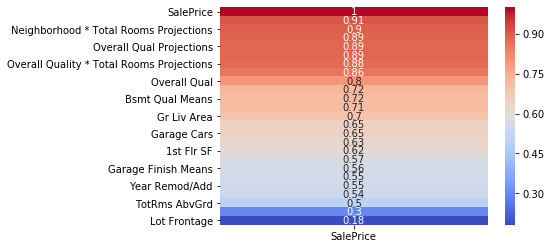

In [112]:
sns.heatmap(pd.DataFrame(final_df.corr()['SalePrice'].sort_values(ascending=False)), annot=True, cmap='coolwarm')

In [113]:
X = final_df.drop(columns='SalePrice')
y = final_df['SalePrice']

In [114]:
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names(final_df.drop(columns='SalePrice').columns))

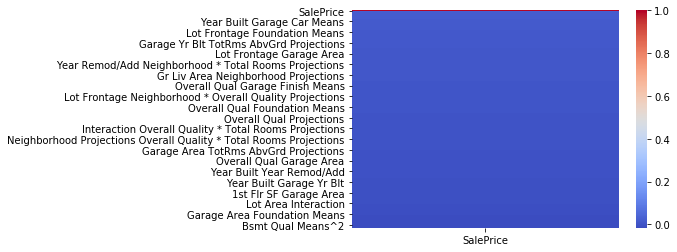

In [115]:
sns.heatmap(pd.DataFrame(X_poly_df.join(y).corr()['SalePrice'].sort_values(ascending=False)), cmap='coolwarm');

In [116]:
y_log = np.log1p(y)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y_log, random_state=7)

In [118]:
ss = StandardScaler()
X_train = pd.DataFrame(ss.fit_transform(X_train))
X_test = pd.DataFrame(ss.transform(X_test))

In [121]:
ridge = RidgeCV()
r_alphas = np.logspace(1, 2.2, 100)
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_model = ridge_model.fit(X_train, y_train)

In [122]:
ridge_model.alpha_

37.127607967640046

In [123]:
y_pred = np.expm1(ridge_model.predict(X_test))
y_test_exp = np.expm1(y_test)

In [124]:
print(f"Training R2: \t{round(ridge_model.score(X_train, y_train), 3)}")
print(f"Test R2: \t{round(ridge_model.score(X_test, y_test), 3)}")
print(f"RMSE: \t\t{int(round(np.sqrt(mean_squared_error(y_test_exp, y_pred))))}")

Training R2: 	0.885
Test R2: 	0.889
RMSE: 		24145


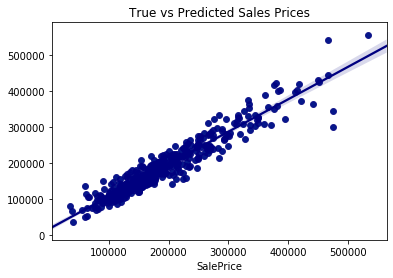

In [125]:
sns.scatterplot(y_test_exp, y_pred).set_title('True vs Predicted Sales Prices')
sns.regplot(y_test_exp, y_pred, color='navy');

In [126]:
residuals = pd.DataFrame(y_test_exp - y_pred)

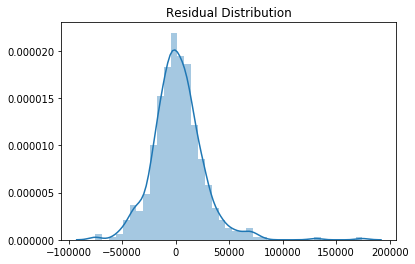

In [127]:
sns.distplot(residuals).set_title('Residual Distribution');

In [128]:
residuals.max()

SalePrice    174571.064529
dtype: float64